In [ ]:
!pip install PyMuPDF nltk textblob spacy wordcloud matplotlib scikit-learn
!python -m textblob.download_corpora
!python -m spacy download de_core_news_sm

  Using cached matplotlib-3.10.3-cp310-cp310-macosx_10_12_x86_64.whl.metadata (11 kB)
  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_x86_64.whl.metadata (62 kB)
  Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-macosx_10_9_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 259.7 kB/s eta 0:00:00a 0:00:01
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_x86_64.whl (6.9 MB)
Using cached matplotlib-3.10.3-cp310-cp310-macosx_10_12_x86_64.whl (8.2 MB)
Using cached contourpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl (268 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 238.2 kB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.8-cp310-cp310-macosx_10_9_x86_64.whl (66 kB)
Using cached py

# verbesserte Extrahierung Versprechen

# weitere Analysen


📊 Keyword-Analyse:
porsche: 142
konzern: 48
2030: 42
ziel: 37
fahrzeuge: 31
sollen: 29
mehr: 25
wertschöpfungskette: 24
jahr: 22
ziele: 22
nachhaltigkeit: 20
text: 20
unmittelbaren: 20
sowie: 19
seit: 18
emissionen: 18
nachhaltigkeitsversprechen: 17
2023: 15
mindestens: 15
produzierten: 14

💬 Sentimentanalyse:
Polarity: 0.04, Subjectivity: 0.32

📅 Zieljahre und Formulierungen:
Jahre gefunden: ['2020', '2021', '2023', '2025', '2026', '2040', '2024', '2022', '2030']
Ziele:
- bis 2030 mit 90 % ihres Einkaufvolumens an Produktionsmaterialien die höchsten internen Qualitätsstandards der Nachhaltigkeit zu erfüllen.
- bis 2025.
- bis 2025 um 45 % reduzieren.
- bis 2030 um 50 % gesenkt werden (Vergleichsjahr: 2018).
- bis 2040 um 95 % gesenkt werden (Vergleichsjahr: 2018).
- Bis 2025 sollen im Rahmen der Vision einer "Zero Impact Factory" verbindliche Ziele für mehr Biodiversität am Standort Stuttgart-Zuffenhausen definiert werden, die auch die direkte Nachbarschaft zum FFH-Schutzgebiet (FFH-

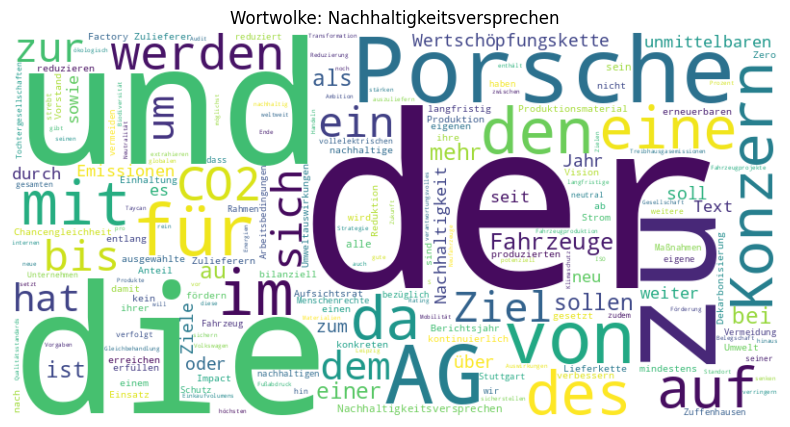

In [31]:
import fitz  # PyMuPDF
import nltk
from textblob import TextBlob
import re
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load("de_core_news_sm")

# === 1. PDF einlesen ===
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    doc.close()
    return text.strip()

# === 2. Keyword-Analyse ===
def keyword_analysis(text, top_n=20):
    words = re.findall(r'\b\w{4,}\b', text.lower())
    keywords = [w for w in words if w not in nltk.corpus.stopwords.words("german")]
    freq = Counter(keywords)
    return freq.most_common(top_n)

# === 3. Sentimentanalyse ===
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# === 4. Zeitangaben & Ziel-Extraktion ===
def extract_targets_and_years(text):
    years = re.findall(r"\b(20[2-4][0-9])\b", text)
    goals = re.findall(r"(bis\s+20[2-4][0-9].*?[\.\n])", text, re.IGNORECASE)
    return list(set(years)), goals

# === 5. ESG-Kategorisierung (vereinfachte Regel-Logik) ===
def categorize_by_esg(sentences):
    esg_map = {"E": ["klima", "co2", "energie", "erneuerbar", "umwelt", "emission"],
               "S": ["vielfalt", "menschen", "arbeit", "weiterbildung", "soziale", "gesellschaft"],
               "G": ["verantwortung", "strategie", "compliance", "führung", "management"]}

    results = []
    for s in sentences:
        category = []
        for k, keywords in esg_map.items():
            if any(kw in s.lower() for kw in keywords):
                category.append(k)
        results.append((s.strip(), category if category else ["Unklar"]))
    return results

# === 6. LLM-basierte Vagheitsbewertung (wenn Ollama verfügbar) ===
def rate_clarity_with_llm(promises):
    try:
        from ollama_api import OllamaApi
    except ImportError:
        print("⚠️ OllamaApi nicht gefunden – Bewertung übersprungen.")
        return []

    rated = []
    for promise in promises:
        prompt = (
            f"Bewerte die Klarheit dieses Nachhaltigkeitsversprechens auf einer Skala von 1 (sehr vage) "
            f"bis 5 (sehr konkret). Gib eine Zahl und eine kurze Begründung zurück.\n\n"
            f"Versprechen: {promise}"
        )

        schema = {
            "type": "object",
            "properties": {
                "bewertung": {"type": "integer"},
                "begruendung": {"type": "string"}
            },
            "required": ["bewertung", "begruendung"]
        }

        result = OllamaApi.completion(prompt, schema=schema)
        rated.append({
            "text": promise,
            "bewertung": result.get("result", {}).get("bewertung"),
            "begruendung": result.get("result", {}).get("begruendung")
        })

    return rated

# === 7. Wordcloud ===
def generate_wordcloud(text):
    wc = WordCloud(width=800, height=400, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title("Wortwolke: Nachhaltigkeitsversprechen")
    plt.show()

# === Hauptablauf ===
if __name__ == "__main__":
    path = "./reports/teyt.pdf"
    text = inhalt_porsche

    print("\n📊 Keyword-Analyse:")
    for word, freq in keyword_analysis(text):
        print(f"{word}: {freq}")

    print("\n💬 Sentimentanalyse:")
    polarity, subjectivity = sentiment_analysis(text)
    print(f"Polarity: {polarity:.2f}, Subjectivity: {subjectivity:.2f}")

    print("\n📅 Zieljahre und Formulierungen:")
    years, goals = extract_targets_and_years(text)
    print(f"Jahre gefunden: {years}")
    print("Ziele:")
    for g in goals:
        print("-", g.strip())

    print("\n🔎 ESG-Kategorisierung:")
    sentences = [s.strip() for s in text.split("\n") if len(s.strip()) > 20]
    esg_results = categorize_by_esg(sentences)
    for sent, cats in esg_results:
        print(f"[{', '.join(cats)}] {sent}")

    print("\n🧠 (Optional) Vagheitsbewertung mit LLM:")
    rated = rate_clarity_with_llm(sentences[:5])  # Begrenze auf 5 zur Demo
    for r in rated:
        print(f"{r['bewertung']}/5 – {r['text']}\n→ {r['begruendung']}\n")

    print("\n☁️ Wordcloud wird angezeigt...")
    generate_wordcloud(text)


In [29]:
from umap import UMAP
import hdbscan
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

umap_model = UMAP(n_neighbors=3, n_components=5, metric='cosine')
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean', prediction_data=True)

topic_model = BERTopic(
    language="german",
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
)

topics, probs = topic_model.fit_transform(inhalt)

topic_info = topic_model.get_topic_info()
print(topic_info)

print("\nBeispiel Topic 1:")
print(topic_model.get_topic(1))

PackageNotFoundError: No package metadata was found for The 'numpy>=1.17' distribution was not found and is required by this application. 
Try: `pip install transformers -U` or `pip install -e '.[dev]'` if you're working with git main

In [ ]:
promise_vw = """
**Lieferantenmanagement**

* Ziel: 80% der direkten Lieferanten mit zertifiziertem Umweltmanagementsystem gemäß ISO-14001- oder EMAS-Validierung (2023)
* Ziel: 85% der direkten Lieferanten mit zertifiziertem Umweltmanagementsystem gemäß ISO-14001- oder EMAS-Validierung (2022)
* Anteil der neuen Lieferanten, die anhand von Sozial- und Umweltkriterien bewertet wurden: 26% (2023) bzw. 12% (2022)

**Nachhaltigkeitsanforderungen**

* Alle Lieferanten müssen unsere Nachhaltigkeitsanforderungen erfüllen.
* Lieferanten mit einem A- oder B-Rating erfüllen unsere Anforderungen in ausreichendem Umfang und sind somit vergabefähig.

**Rohstofflieferketten**

* Ziel: Transparenz in der Lieferkette für Batterierohstoffe Kobalt, Lithium, Nickel und natürliches Graphit herstellen.
* Umsetzung der "Due Diligence Guidance for Responsible Business Conduct" der OECD und die Anforderungen der "OECD Due Diligence Guidance for Responsible Supply Chains of Minerals from Conflict-Affected and High-Risk Areas".

**Menschenrechte**

* Engagement für den Schutz von Gruppen, die entlang unserer Lieferkette einem hohen Risiko potenzieller Menschenrechtsverletzungen ausgesetzt sein können.
* Ziel: das soziale Wohlergehen der Menschen vor Ort verbessern und die Gesundheits- und Sicherheitsbedingungen verbessern.

**Dekarbonisierung**

* Ziel: Dekarbonisierung in der Lieferkette vorantreiben.

Insgesamt zeigt der Text, dass der Volkswagen-Konzern sich für eine nachhaltige und verantwortungsvolle Lieferkettenpolitik einsetzt und konkrete Ziele und Maßnahmen ergreift, um diese Ziele zu erreichen."""

In [25]:
inhalt = """
### Extrahierte Nachhaltigkeitsversprechen aus 2023_Volkswagen_Group_Nachhaltigkeitsbericht.pdf:

--- Chunk 1 ---
Ich bin bereit, dir zu helfen! Bitte füge den Text hinzu, aus dem ich die Nachhaltigkeitsversprechen extrahieren soll.

--- Chunk 2 ---
* "Wir verfolgen das Ziel, unsere Leistung in ESG-Ratings und -Rankings des Kapitalmarkts zu verbessern, um die Investitionsfähigkeit zu steigern und Kapitalkosten zu optimieren."
* "Wir beabsichtigen, Fortschritte bei Transparenz und Risikominderung in den Rohstofflieferketten (jährlich) im Responsible Raw Materials Report darzustellen."
* "Wir streben die Umsetzung nachhaltiger Finanzierungsstrategien an, die jährlich im Green Finance Report dargestellt werden sollen."
* "Wir verpflichten uns zur Umsetzung der zehn UN-Global-Compact-Prinzipien, die jährlich berichtet wird."

--- Chunk 3 ---
ein weltweit führender Anbieter nachhaltiger Mobilität zu sein

--- Chunk 4 ---
Bis 2030 soll der CO2-Fußabdruck des gesamten Handelsnetzes um mindestens 30 % gesenkt werden. 
Zugang zu 600.000 Ladepunkten in Europa

--- Chunk 5 ---
* Mehr als 850.000 t CO2 wurden seit 2017 durch den AluminiumClosed-Loop bilanziell eingespart. 
* 2023 haben wir 77.090 Werkzeuge bearbeitet, sodass sie für ihren erneuten Einsatz geeignet sind.

--- Chunk 6 ---
Unser Ziel ist es, die Natur und die Gesellschaft positiv mitzugestal ten.

--- Chunk 7 ---
Nachhaltigkeit als Strategie: klare Ziele, klare Verantwortung Nachhaltigkeit gehört bei uns zu den Top-Prioritäten. Als strategisches Feld setzen wir uns in der Nachhaltigkeit klare Ziele und Pläne – verbindlich und mit eindeutigen Verantwort lichkeiten.

--- Chunk 8 ---
Unser Ziel ist es, die produktionsbedingten CO2-Emissionen von Pkw und leichten Nutzfahrzeugen bis 2030 um 50,4 Prozent im Vergleich zum Basisjahr 2018 zu reduzieren.

--- Chunk 9 ---
Die renommierte Science Based Targets Initiative (SBTi) hat bestätigt, dass unser Unternehmen mit dieser Zielsetzung für die Produktionsphase (Scope 1 und 2) die Voraussetzungen erfüllt, mit dazu beizutragen, die Erderwärmung auf 1,5 Grad Celsius zu begrenzen. 
Das Ziel, die CO2-Emissionen in der Nutzungsphase (Scope 3) um 30 Prozent zu reduzieren

--- Chunk 10 ---
Der Volkswagen Konzern strebt bis zum Jahr 2030 eine Senkung des durchschnittlichen CO2-Ausstoßes pro Fahrzeug (Pkw und leichte Nutzfahrzeuge) über den gesamten Lebenszyklus im Vergleich zu 2018 um 30 Prozent an.
Bis 2025 sollen in mehreren Regionen Europas neue Wind- und Solarparks entstehen.

--- Chunk 11 ---
Veränderungen steuern und begleiten wir nachhaltig sozial im Sinne unserer Kolleginnen und Kollegen.

--- Chunk 12 ---
Beschäftigungssicherung bis 2029 in der Volkswagen AG

--- Chunk 13 ---
Der Schutz der Menschenrechte
die Minimierung umweltbezogener Risiken

--- Chunk 14 ---
Bis zum Jahr 2025 möchte der Volkswagen Konzern die Inbetriebnahme von mehr als 40.000 Schnellladepunkten in China, Nordamerika und Europa ermöglichen.

--- Chunk 15 ---
Wir wollen nachhaltige Mobilität für Generationen ermöglichen.

--- Chunk 16 ---
Als Mitglied des Global Compact der Vereinten Nationen (UN Global Compact) berichten wir außerdem kontinuierlich, wie wir die zehn Prinzipien in die Unternehmenspraxis um setzen.

--- Chunk 17 ---
Die nachhaltige Wertschöpfung wird priorisiert über das Volumenwachstum.

--- Chunk 18 ---
Verwertung der Fahrzeuge am Ende ihrer Lebensdauer achten wir bereits bei der Entwicklung neuer Fahrzeuge auf 
die Recyclingfähigkeit der benötigten Werkstoffe, 
die Verwendung von qualitativ hochwertigem Recyclingmaterial und 
die Vermeidung von Schadstoffen.

--- Chunk 19 ---
ein weltweit führender Anbieter nachhaltiger Mobilität zu sein

--- Chunk 20 ---
Kein Nachhaltigkeitsversprechen gefunden.

--- Chunk 21 ---
Kein Nachhaltigkeitsversprechen gefunden.

--- Chunk 22 ---
Eine zukunftsorientierte Mechatronikplattform soll (...) die nachhaltige Wettbewerbsfähigkeit bei Volkswagen bilden.

--- Chunk 23 ---
wir wollen uns zu einem profitablen Experten entlang des gesamten Batterielebenszyklus entwickeln.

--- Chunk 24 ---
Unser vorrangiges Ziel ist es...bis zum Jahr 2030 in bis zu 80 % der Konzernmodelle zum Ein satz kommen soll.

--- Chunk 25 ---
So soll der rasant ansteigende Bedarf an Batteriezellen bis 2030 etwa zur Hälfte selbst gedeckt werden.

--- Chunk 26 ---
Bis zum Jahr 2025 sind gemeinsam mit Partnern rund 45.000 Schnellladepunkte (HPC – High-Power-ChargingPunkte) in Europa, China und den USA geplant.

--- Chunk 27 ---
Ladevorgänge sollen dann gezielt so gesteuert werden, dass erneuerbare Energien geladen und Stromnetze entlastet werden können.

--- Chunk 28 ---
Wir bekennen uns zum Pariser Klimaschutzabkommen und richten unsere Aktivitäten am 1,5-Grad-Ziel aus. Bis 2050 beabsichtigen wir, ein bilanziell CO2-neutrales Unternehmen zu sein. Außerdem haben wir uns zum Ziel gesetzt, eine CO2-Reduktion von Pkw und leichten Nutzfahrzeugen über den gesamten Lebenszyklus von 30 % in 2030 im Vergleich zu 2018 zu erreichen.

--- Chunk 29 ---
* Wir möchten den Anteil von erneuerbaren Energien in der Produktentstehung erhöhen.
* Wir möchten den Anteil an kreislauffähigen Materialien in unseren Fahrzeugen erhöhen. 
* Wir möchten als Benchmark für ethisch handelnde Unternehmen gelten.

--- Chunk 30 ---
Das Management des Konzerns soll daher bis 2025 mindestens zu einem Fünftel aus Frauen und mindestens zu einem Viertel aus internationalen Managern bestehen.

--- Chunk 31 ---
Die dafür benötigte Schlüsseltechnologie soll bis 2030 in einem Großteil der plattformbasierten Fahrzeuge integriert sein.

--- Chunk 32 ---
Bis 2030 soll Nordamerika zur dritten Kernregion neben Europa und China werden.

--- Chunk 33 ---
Wir unser konzernweites Angebot an vollelektrischen Modellen massiv ausbauen

--- Chunk 34 ---
Der Anteil batterieelektrischer Fahrzeuge an unseren Verkäufen in den USA und Kanada soll bis 2030 auf 55 % steigen.

--- Chunk 35 ---
nachhaltige Reduzierung von Kosten zur langfristigen Absicherung der Profitabilität

--- Chunk 36 ---
Ein nachhaltiger Konzern

--- Chunk 37 ---
nachhaltig seine Fixkostenstruktur, die Produktivität der Werke, die Kosten der Beschaffung, die Vertriebskosten und das Working-Capital-Management zu optimieren

--- Chunk 38 ---
Operative Umsatzrendite ... 9 bis 11 %
Investitionsquote im Konzernbereich Automobile1 ... ~ 9 %
Cash Conversion Rate im Konzernbereich Automobile ... > 60 %
Nettoliquidität im Konzernbereich Automobile ... ~ 10 % der Umsatzerlöse des Konzerns
Kapitalrendite (RoI) im Konzernbereich Automobile ... > 18 %

--- Chunk 39 ---
...die zu einer kontinuierlichen Verbesserung der Nachhaltigkeitsleistung führt.

--- Chunk 40 ---
Unser Aktionsprogramm, das auf eine Verbesserung unserer Resultate in ESG-Ratings bis zum Jahr 2025 abzielt.

--- Chunk 41 ---
Wir streben an, die negativen Auswirkungen von rechtlichen oder medial ausgetragenen Kontroversen bezüglich des Volkswagen Konzerns auf unsere Rating-Resultate zu reduzieren.

--- Chunk 42 ---
Wir arbeiten an der Establishment eines umfassenden ESG-Data-Reporting-Tools für eine bessere datengestützte Infrastruktur und streben an, zukünftig umfassende ESG-Informationsangebote für relevante Stakeholder zu schaffen.

--- Chunk 43 ---
Der Volkswagen Konzern will die Wirkung seines Handelns (Impact) künftig noch umfassender quantitativ messen.

--- Chunk 44 ---
Entwicklung einheitlicher Bewertungsstandards für die ImpactBewertung sowie die finanzielle Bilanzierung von Nachhaltigkeitswirkungen.

--- Chunk 45 ---
leisten. Hierfür wurde ein umfassendes Nachhaltigkeitsmanagement etabliert

--- Chunk 46 ---
Unter dem neuen Green Finance Framework werden nur noch Investitionen für BEV des Volkswagen Konzerns berücksichtigt, die EU-taxonomiekonform sind.

--- Chunk 47 ---
bi-lanzenelle CO2-Neutralität bis 2050

--- Chunk 48 ---
* Reduzierung der weltweiten Umweltbelastung durch die Förderung von umweltverträglichen Projekten
* Erfüllung der Ziele der Vereinten Nationen für nachhaltige Entwicklung (Sustainable Development Goals, SDGs)
* Einhaltung der Green Bond Principles der International Capital Market Association (ICMA), insbesondere in der Kategorie "Clean Transportation"

--- Chunk 49 ---
* zum Klimaschutz beitragen

--- Chunk 50 ---
Es ist daher wichtig, eine Bewertungsbasis zu schaffen, damit Mobilitätslösungen in ihrer Nachhaltigkeitswirkung abgeschätzt und beeinflusst werden können.

--- Chunk 51 ---
Minderung der CO2-Emissionen

--- Chunk 52 ---
Städte wollen möglichst wenig Fläche mit Verkehr belegen und die Luftqualität verbessern, für den Betreiber von Mobilitätsangeboten ist eine gute Auslastung seines Angebots unverzichtbar.

--- Chunk 53 ---
das Laden bzw. die Rückspeisung soll während der Standzeit des Fahrzeugs mit der Verfügbarkeit von erneuerbarer Energie synchronisiert werden

--- Chunk 54 ---
Gesellschaftliche Teilhabe verbessern

--- Chunk 55 ---
Bis 2026 soll Astypalea nun zu einer smarten und grünen Insel transformiert werden.

--- Chunk 56 ---
2024 soll ... ein Batteriespeicher ergänzt werden ..., um ... bis zu 60 % des gesamten Energiebedarfs der Insel mit regenerativer Energie zu decken.

--- Chunk 57 ---
Dekarbonisierung 
Kreislaufwirtschaft 
Integrität und Compliance 
Lieferkette und Menschenrechte

--- Chunk 58 ---
Wir möchten... alle Stakeholder gleicher maßen berücksichtigen.

--- Chunk 59 ---
Unser Ziel ist, unser Unter nehmen... seine Akzeptanz und Reputation nachhaltig zu verbessern.

--- Chunk 60 ---
2024 sollen ein systematischer Analyseprozess für Stakeholder implementiert werden.

--- Chunk 61 ---
Umweltauflagen konsequent einhalten: Die Einhaltung umweltbezogener Gesetze und Vorgaben an allen unseren Standorten hat für Volkswagen hohe Priorität.

--- Chunk 62 ---
unserer Umweltleistung kontinuierlich zu verbessern und unsere Umweltauswirkungen zu verringern.

--- Chunk 63 ---
Dekarbonisierung 
Umweltverträglichkeit unserer Produkte, Dienstleistungen und Prozesse.

--- Chunk 64 ---
Unser Umweltleitbild goTOzero verfolgt das Ziel, unseren ökologischen Fußabdruck über den gesamten Lebenszyklus unserer Produkte und Mobilitätsangebote zu verringern.

--- Chunk 65 ---
Umweltauswirkungen entlang des gesamten Lebenszyklus - von der Rohstoffgewinnung bis zum Lebensende - für alle unsere Produkte und Mobilitätslösungen zu reduzieren, um Ökosysteme intakt zu halten.

--- Chunk 66 ---
KLIMA schützen 
Wir bekennen uns zum Pariser Klimaschutzabkommen und streben ein 1,5-Grad-Ambitionsniveau an.

--- Chunk 67 ---
Bis spätestens 2050 wollen wir ein bilanziell CO2-neutrales Unternehmen sein.

--- Chunk 68 ---
Wir verbessern unsere Energieund Ressourceneffizienz 
Gemeinsam mit unseren Geschäftspartnern verringern wir die Beanspruchung natürlicher Ressourcen entlang unserer Lieferkette.

--- Chunk 69 ---
die ökologischen Auswirkungen unserer Prozesse, Produkte und Dienstleistungen zu verringern 
bindende Verpflichtungen zu erfüllen
das Umwelt-Compliance-Managementsystem sowie die Umweltleistung kontinuierlich zu verbessern

--- Chunk 70 ---
Die konzernweite Steuerung des Umweltschutzes erfolgt durch den Konzernsteuerkreis Umwelt und Energie. Dies schließt die Umsetzung der Programme zur Ressourceneffizienz und die Kontrolle der Zielerreichung ein.

--- Chunk 71 ---
Zum Nachweis der Zielerreichung werden jährlich die wesentlichen Umweltkenn zahlen offengelegt.

--- Chunk 72 ---
Wir wollen das Management von chemischen Substanzen weiter verbessern.

--- Chunk 73 ---
Den Einsatz gefährlicher Chemikalien reduzieren

--- Chunk 74 ---
Die Volkswagen AG identifiziert auf Basis der Ökobilanzen für ihre Fahrzeuge Hotspots im Lebenszyklus und leitet daraus geeignete Lösungen ab, um die Umweltauswirkungen zu reduzieren.

--- Chunk 75 ---
Bis 2025 sollen die produktionsbedingten Umweltbelastungen an allen Standorten zur Fertigung von Pkw und leichten Nutzfahrzeugen im Vergleich zu 2010 um 45 % pro Fahrzeug reduziert werden.

--- Chunk 76 ---
• Energiebedarf pro Fahrzeug: –21,0 % (2022: –14,2 %)
• CO2-Emissionen pro Fahrzeug: –51,0 % (2022: –43,0 %)
• Wasserverbrauch pro Fahrzeug: –24,7 % (2022: –17,4 %)
• Abfall zur Beseitigung pro Fahrzeug: –75,9 % (2022: –68,5 %) 
• VOC-Emissionen pro Fahrzeug: –68,7 % (2022: –66,0 %)

--- Chunk 77 ---
eine Fabrik ohne negative Auswirkungen auf die Umwelt.

--- Chunk 78 ---
Erfassen und Reduzieren der quantitativen Umweltauswirkungen unserer Produktionsstandorte

--- Chunk 79 ---
Projekte und Maßnahmen zum Erhalt der Biodiversität,
zur Etablierung einer umweltfreundlichen Mitarbeitermobilität 
oder zur Förderung der Kreislaufwirtschaft.

--- Chunk 80 ---
Strategische Reduzierung von Ressourcen und Emissionen 
45 % Reduktion absoluter Umweltauswirkungen der Produktion bis 2025 global lokal

--- Chunk 81 ---
Bis 2050 streben wir einen "Zero Impact"-Status für alle Standorte zur Fertigung von Pkw und leichten Nutzfahrzeugen an.

--- Chunk 82 ---
Durch eine Kreislaufführung beziehungsweise die Rückfüh rung von Kühl- und Prozesswasser können der Frischwasser bedarf sowie die Abwassermenge deutlich gesenkt werden. 
An allen unseren Konzernstandorten fördern wir wasserspa rende Prozesse in der Produktion mit zentralen Vorgaben.

--- Chunk 83 ---
Im Rahmen des CBD und der 15. Weltnaturkonferenz (CBD COP 15) haben wir im Jahr 2022 unser Biodiversität-Commitment mit seinen sechs Handlungsfeldern weiter konkretisiert.

--- Chunk 84 ---
Wir haben uns zum Ziel gesetzt, die Biodiversität auch an den Produktionsstandorten zu erhöhen. Lokale Maßnahmen umfassen das Anlegen von Blühwiesen, das Anpflanzen von Bäumen und Sträuchern und das Aufstellen von Nisthilfen für Fledermäuse, Vögel und Insekten.

--- Chunk 85 ---
Die Biodiversität an den Produktionsstandorten transparent zu machen und schrittweise zu erhöhen.

--- Chunk 86 ---
* Standorte mit ISO-14001-Zertifizierung oder EMAS-Validierung: 99,9% der Mitarbeiterzahl im Volkswagen Konzern und 100% der Mitarbeiterzahl in der Volkswagen AG (bezogen auf die Mitarbeiterzahl an allen Produktionsstandorten)
* Standorte mit ISO-50001-Zertifizierung: 88,5% des Endenergieverbrauchs der Produktionsstandorte im Volkswagen Konzern und 100% des Endenergieverbrauchs der Produktionsstandorte in der Volkswagen AG (bezogen auf den Endenergieverbrauch)
* Umweltentlastung Produktion (UEP): 
 + Veränderung UEP, gesamt: -44,2% im Volkswagen Konzern und -21,1% in der Volkswagen AG
 + Veränderung spezifischer Energiebedarf: -21,0% im Volkswagen Konzern und -11,5% in der Volkswagen AG
 + Veränderung spezifische CO2-Emissionen: -51,0% im Volkswagen Konzern und -23,7% in der Volkswagen AG
 + Veränderung spezifische VOC-Emissionen: -68,7% im Volkswagen Konzern und -18,8% in der Volkswagen AG
 + Veränderung spezifischer Wasserverbrauch: -24,7% im Volkswagen Konzern und -10,2% in der Volkswagen AG
 + Veränderung spezifischer Abfall zur Beseitigung: -75,9% im Volkswagen Konzern und -49,7% in der Volkswagen AG

--- Chunk 87 ---
Bis 2025 wird der zusätzliche jährliche GRC-Regelprozess durch ein standardisiertes IKS ersetzt.

--- Chunk 88 ---
Die Master-Kontroll kataloge werden jährlich auf Aktualität hin geprüft und bei Bedarf angepasst.

--- Chunk 89 ---
Kein Text zu Nachhaltigkeitsversprechen mit konkreten Zielen vorhanden.

--- Chunk 90 ---
Wir bekennen uns zum Pariser Klimaschutzabkommen und richten unsere eigenen Aktivitäten am 1,5-Grad-Ziel aus. Bis 2050 beabsichtigen wir, ein bilanziell CO2-neutrales Unternehmen zu sein.

--- Chunk 91 ---
Im vierten Zielfeld die Wirkungsdimension "We@Volkswagen and the world around us" das strategische Ziel "Aligned with Society and Environment".

--- Chunk 92 ---
Auf dem Weg zum bilanziell CO2-neutralen Unternehmen

--- Chunk 93 ---
* Bis 2050 soll der globale Temperaturanstieg auf deutlich unter 2 Grad Celsius begrenzt werden.
* Bis zum Jahr 2050 will Volkswagen ein bilanziell CO2-neutrales Unternehmen sein.
* Bis 2030 wollen wir den CO2-Fußabdruck unserer Pkw und leichten Nutzfahrzeuge um 30 % (gegenüber 2018) pro Fahrzeug verringern.

--- Chunk 94 ---
das Ziel [...] ohne Kompen sationsmaßnahmen erreichen
die gesamte Stromversorgung unserer Werke auf erneuerbare Energien umzustellen

--- Chunk 95 ---
bis 2027: 
mehr als zwei Drittel (68 %) der geplanten Investitionen fließen in die Zukunftsfelder Digitalisierung und Elektrifizierung.

--- Chunk 96 ---
goTOzero ... für eine bilanziell CO2-neutrale Wirtschaftsweise.

--- Chunk 97 ---
Dekarbonisierung, 
- DKI (Dekarbonisierungsindex): Dieser Index misst den Fortschritt der Dekarbonisierung. Ziel: Klimaneutralität des Konzerns bis 2050.

--- Chunk 98 ---
Darüber hinaus ist ab 2023 mit Einführung eines ESG-Faktors im Jahresbonus auch die Zielerreichung des DKI in der Managementvergütung verankert.

--- Chunk 99 ---
Der Konzern begegnet dem Risiko, indem die Energieversorgung langfristig auf erneuerbare Energien umgestellt und entsprechende Quoten für die Nutzung von regenerativ erzeugtem Strom in lieferantenseitige Beschaffungsanforderungen integriert werden.

--- Chunk 100 ---
Der Konzern begegnet dem Risiko einerseits durch die Zertifizierung seiner selbst gesetzten Dekarbonisierungsziele mittels unabhängiger und international anerkannter Organisationen

--- Chunk 101 ---
...hin zu einem führenden Anbieter nachhaltiger Mobilität dienen.

--- Chunk 102 ---
Der Konzern begegnet diesem Risiko, indem stetig neue und verbrauchsgünstige Fahrzeuge und alternative Antriebe entwickelt werden.

--- Chunk 103 ---
Dekarbonisierungsziele

--- Chunk 104 ---
Der Konzern begegnet diesem Risiko mit der gezielten Förderung des Aufbaus zusätzlicher Erzeugungskapa zitäten für Strom aus erneuerbaren Quellen sowie der langfristigen Kontrahierung bestehender Ressourcen.

--- Chunk 105 ---
nachhaltige Verbesserungen der Kapitalmarktperformance zu erreichen

--- Chunk 106 ---
CO2-Neutralität bis 2050

--- Chunk 107 ---
Als Mitglied in der Arbeitsgruppe des Mobility Model (MoMo) der International Energy Agency (IEA) nutzen wir beispielsweise sogenannte IEA-ETP-Szenarien ("Energy Technology Perspectives"), darunter das "2°C Scenario" (2DS). Wir konzentrieren uns auf das Zieljahr 2030, das einen Meilenstein auf dem Weg zur bilanziellen CO2-Neutralität des Konzerns bis 2050 darstellt.

--- Chunk 108 ---
Um die UN-Klimaziele zu erreichen, ist eine deutliche Verringerung der Emissionsintensität pro Fahrzeug notwendig,

--- Chunk 109 ---
Der Konzern will die Energieversorgung in der gesamten Wertschöpfungskette und in allen Lebensphasen eines Fahrzeugs sukzessive auf regenerative Energie umstellen.

--- Chunk 110 ---
den durchschnittlichen globalen Temperaturanstieg bis 2100 auf 2 Grad Celsius zu begrenzen

--- Chunk 111 ---
den durchschnittlichen globalen Temperaturanstieg auf 1,75 Grad Celsius begrenzen

--- Chunk 112 ---
Umstellung auf erneuerbare Energiequellen entlang der gesamten Wertschöpfungskette

--- Chunk 113 ---
CO2-neutrale Mobilität

--- Chunk 114 ---
Die Auslieferung des voll-elektrischen Kompaktwagens ID.3 erfolgt bilanziell CO2-neutral.

--- Chunk 115 ---
Uns ist wichtig, insbesondere die Nutzungsphase unserer Fahrzeuge langfristig emissionsfrei zu gestalten.

--- Chunk 116 ---
* Eine bilanziell nahezu CO2-neutrale Mobilität ermöglichen.

--- Chunk 117 ---
Bis 2025 sollen so in verschiedenen Regionen Europas neue Wind- und Solarparks entstehen.

--- Chunk 118 ---
Bis zum Jahr 2025 sollen alle Projekte zusammen rund 7 TWh an zusätzlichem Ökostrom erzeugen.

--- Chunk 119 ---
Alle Lieferanten (Neuvergaben) von HV-Batterien werden bereits heute vertraglich dazu verpflichtet, zertifizierten Strom aus erneuerbaren Quellen in ihrer Produktion einzusetzen. Damit sinkt der CO2-Ausstoß in der Batteriefertigung.

--- Chunk 120 ---
Bei neuen Fahrzeugprojekten macht der Volkswagen Konzern die CO2-Emissionen in Zukunft zu einem technischen Merkmal für relevante Bauteile.

--- Chunk 121 ---
Batterien der SSP-Plattform mit einem CO2-Grenzwert versehen

--- Chunk 122 ---
Die CO2-Bilanz der ID.-Familie soll in den nächsten Jahren um rund zwei Tonnen je Fahrzeug verbessert werden.

--- Chunk 123 ---
Die Gruppe entwickelt zusammen mit Lieferanten und Partnern einen Fahrplan für die Umstellung auf 100 % erneuerbare Energien bis 2030.

--- Chunk 124 ---
* bis zu 200 Gigawattstunden (GWh) Gesamt-Produktionspotenzial
* Betrieb aller Standorte mit Strom aus erneuerbaren Quellen
* Abdeckung von bis zu 30 % des Strombedarfs in Spanien durch einen angrenzenden Photovoltaik-Park
* Berücksichtigung von mehr als 30 absehbaren Produkt- und Prozessinnovationen bis Ende der Dekade

--- Chunk 125 ---
* Reduzierung des Energieverbrauchs um 30 % bei der Zellfertigung durch das Dry-Coating-Verfahren
* Reduzierung der benötigten Fabrikfläche um 15 %
* Senkung der Fertigungskosten (ohne spezifische Angabe)

--- Chunk 126 ---
Die PowerCo-Zellfabriken sind künftig darauf ausgelegt, die Materialnutzung innerhalb der Produktion durch fertigungsnahes Recycling der Produktionsüberschüsse (scrap sowie end-of-line) zu maximieren. Zudem setzen der Konzern und PowerCo auf konsequentes End-of-Life-Recycling und die Nutzung von Rezyklaten.

--- Chunk 127 ---
Die Partner streben an, bis 2030 Produktionskapazitäten für Kathodenmaterial und Vorläufermaterialien aufzubauen, die einer jährlichen Zellproduktion von 160 GWh entsprechen, genug für 2,2 Mio. batterieelektrische Fahrzeuge.

--- Chunk 128 ---
den Aufbau regionaler, nachhaltiger und transparenter Wertschöpfungsketten für Batterien beschleunigen
die EU bei der Erreichung der Ziele des Green Deals unterstützen

--- Chunk 129 ---
Bis 2030 etwa 900 Arbeitsplätze entstehen sollen.

--- Chunk 130 ---
Transporte vermieden und Emissionen reduziert werden

--- Chunk 131 ---
nahezu vollständige CO2-Vermeidung durch den Einsatz von Ökostrom im Schienenverkehr in Deutschland und weiteren Ländern

--- Chunk 132 ---
bis Ende 2023 vier weitere Autofrachter mit gleichen Antrieben in Betrieb nehmen und sukzessiv konventionell betriebene Schiffe ablsen.

--- Chunk 133 ---
nahezu kein Methan entweichen kann

--- Chunk 134 ---
Weiterhin eine Reduktion der CO2-Emissionen durch Einsatz von nichtfossilen Treibstoffen und anderen alternativen Treibstoffen.

--- Chunk 135 ---
Volkswagen will den Ausstoß von Treibhausgasemissionen in der Produktion bis 2030 absolut um 50,4 % gegenüber 2018 reduzieren.

--- Chunk 136 ---
Der Volkswagen Konzern hat sich das Ziel gesetzt, von 2018 bis 2030 Energieeffizienzmaßnahmen umzusetzen, die in Summe 4,9 Mio. MWh Energie an den Fertigungsstandorten einsparen.

--- Chunk 137 ---
Bis 2023 konnten bereits 7.822 Maßnahmen in Höhe von 3,0 Mio. MWh um gesetzt werden.

--- Chunk 138 ---
Die Stilllegung der Steinkohleblöcke im Heizkraftwerk Wolfsburg-West ist für den 31. März 2024 geplant.

--- Chunk 139 ---
Volkswagen geht davon aus, dass die ursprünglich avisierte jährliche Einsparung von 1,5 Mio. t CO2 ab dem zweiten Quartal 2024 jährlich realisiert werden kann. 
Die Versorgung der Werke mit Strom aus erneuerbaren Energien kommt weiter voran. So stieg der Anteil am externen Strom bezug innerhalb eines Jahres in den EU-Produktionsstätten von 99,6 % auf 100 %.

--- Chunk 140 ---
Bis 2030 ist dieselbe Zielmarke für alle weltweiten Standorte geplant. 
Volkswagen treibt die Energie wende auch an den eigenen Standorten voran. So haben wir uns das Ziel gesetzt, bis 2030 1,2 Mio. MWh Strom aus erneuerbaren Energien selbst beziehungsweise in unmittelbarer Nähe der Fertigungsstandorte zu erzeugen.

--- Chunk 141 ---
Schnellladeinfrastruktur für Pkw ausbauen

--- Chunk 142 ---
3 Standorte in China: Versorgung mit 100 % erneuerbarem bzw. bilanziell CO2-neutralem Strom.

--- Chunk 143 ---
Bis Ende 2023 will das Unternehmen europa weit 2.800 Schnellladestationen an Fernstraßen errichten. Bis 2025 will das Unternehmen im Verbund mit Partnern rund 18.000 öffentliche Schnellladepunkte in Europa betreiben

--- Chunk 144 ---
• In Nordamerika soll die Ladeinfrastruktur von Electrify America bis 2025 auf mehr als 8.000 Standorte erweitert werden. 
• In China plant Volkswagen über das Joint Venture CAMS insgesamt 17.000 Schnellladepunkte bis 2025. 
Bis 2025 sind gemeinsam mit Partnern insgesamt mehr als 40.000 Schnellladepunkte in Europa, China und in den USA geplant.

--- Chunk 145 ---
Bis 2025 circa 400 Mio. € für das Gesamtprogramm in Europa ausgeben

--- Chunk 146 ---
EUROPA 18.000 Schnellladepunkte Schnellladepunkte bis 2025
NORDAMERIKA 8.000 Schnellladepunkte
CHINA 17.000 Schnellladepunkte

--- Chunk 147 ---
Elektrofahrzeuge CO2-neutral übergeben 
Wir haben als freiwillige Maßnahme bereits 2022 beschlossen, eine Reihe von Elektrofahrzeugen des Konzerns bilanziell CO2-neutral an unsere Kunden in Europa zu übergeben. Auf diese Weise wollen wir ihnen, sofern sie sich für einen Öko stromvertrag für das Laden entscheiden, eine bilanziell nahe zu vollständig CO2-neutrale Mobilität ermöglichen.

--- Chunk 148 ---
Bilanziell CO2-neutrale Auslieferung in Europa.

--- Chunk 149 ---
Dekarbonisierung der Händlernetze...im Rahmen des Projekts "goTOzero retail" arbeitet der Volkswagen Konzern daran, das gesamte Vertriebsnetz zu dekarbonisieren und dessen ESG-Leistung zu steigern.

--- Chunk 150 ---
Demnach soll der CO2-Fußabdruck des gesamten Handelsnetzes – aus gehend von 2020 als Basiswert – bis 2030 um mindestens 30 %, bis 2040 um mindestens 55 % und bis 2050 um mindestens 75 % gesenkt werden.

--- Chunk 151 ---
Ab 2024 sollen sukzessive alle 50 wesentlichen Handelsmärkte an der Zertifizierung teilnehmen, sie decken 95 % des weltweiten Handels- und Servicenetzes ab.

--- Chunk 152 ---
Ab 2024 soll allen Märkten und Partnerbetrieben ein Energie- und Ressourcenberatungskonzept zur Verfügung stehen.

--- Chunk 153 ---
höchstmögliche Energieeffizienz in neu errichteten und bestehenden Gebäuden 
Einsatz erneuerbarer Energien, soweit wirtschaftlich und technisch machbar

--- Chunk 154 ---
* Die Zusätzlichkeit der Emissionsreduktionen
* Die Genauigkeit der Emissionsreduktionen
* Die Permanenz der Emissionsreduktionen 
* Die sozioökonomische und ökologische Vorteilhaftigkeit für die Region

--- Chunk 155 ---
Ziel ist es... Lösungen für die Dekarbonisierung zu entwickeln.

--- Chunk 156 ---
EU zu Vorreiter für Klimaschutz machen: Engagement in der CEO Alliance Volkswagen ist Mitglied in der "CEO Alliance for Europe's Recovery, Reform and Resilience", einer paneuropäischen und sektorübergreifenden Allianz großer Konzerne mit Sitz in Europa, die sich ausdrücklich zum Green Deal der EU und zu den damit verbundenen Klimaschutzzielen bekennen.

--- Chunk 157 ---
Die EU zur weltweit führenden Region im Klimaschutz machen, Investitionen zu beschleunigen, Innovationen voranzutreiben und damit zukunftssichere Jobs zu schaffen.

--- Chunk 158 ---
CO2neutrale Unternehmensgebäude bis 2030

--- Chunk 159 ---
Die CEO Alliance unterstützt außerdem das "Fit for 55"-Programm der EU-Kommission und schlägt rasche Maßnahmen zur 
*   Dekarbonisierung von Mobilität und Verkehr, 
*   Transformation des Gebäudesektors sowie 
*   eine zügige Dekarbonisierung des Energiesystems in der EU vor.

--- Chunk 160 ---
Bis zum Jahr 2050 will der Volkswagen Konzern ein bilanziell CO2-neutrales Unternehmen sein.

--- Chunk 161 ---
Um 50,4 % sollen die produktionsbedingten CO2-Emissionen bis 2030 sinken. Der Konzern hat sich das Ziel gesetzt, die produktionsbe dingten CO2-Emissionen seiner Pkw und leichten Nutzfahr zeuge bis 2030 um 50,4 % zu senken – verglichen mit dem Basisjahr 2018.

--- Chunk 162 ---
Begrenzung der Erdwärmung auf 1,5 Grad Celsius.

--- Chunk 163 ---
* Die CO2-Emissionen in der Nutzungsphase (Scope 3) um 30 % zu reduzieren
* Bis 2030 will das Unternehmen 30 % weniger CO2 im Durchschnitt pro Fahrzeug über den gesamten Lebenszyklus ausstoßen als 2018

--- Chunk 164 ---
Scania verpflichtet sich, seine absoluten Scope-1- und Scope-2-Treibhausgasemissionen bis 2025 um 50 % gegenüber dem Basisjahr 2015 zu reduzieren. Das Unternehmen kündigte 2022 außerdem an, seine Lieferkette bis 2030 weitestgehend zu dekarbonisieren.

--- Chunk 165 ---
Die Scope-3-Treibhausgasemissionen aus der Nutzung der verkauften Fahrzeuge sollen bei Scania bis 2025 um 20 % pro Fahrzeugkilometer sinken.

--- Chunk 166 ---
Verglichen mit 2019 will das Unternehmen seine Scope-1- und Scope-2-Emissionen bis 2030 um 70 % senken, seine Scope-3-Emissionen um 28 %.

--- Chunk 167 ---
Für das Jahr 2024 plant Volkswagen, die für die Basisjahre berichteten CO2-Werte anzupassen.

--- Chunk 168 ---
Reduzierung der CO2-Emissionen

--- Chunk 169 ---
gesetzliches Zielwert von 122 g CO2/km (WLTP)

--- Chunk 170 ---
Eine Zielverschärfung erfolgt ab 2025: Demnach hat die EU-Kommission das Ziel einer CO2-Reduktion von 15 % gegenüber 2021 festgelegt, was für unsere EU-Pkw-Neuwagenflotte einem CO2-Zielwert von unter 100 g CO2/km entspricht. Für das Jahr 2030 wurde eine Absenkung von 55 % festgelegt, dies entspricht einem CO2-Zielwert von unter 50 g CO2/km.

--- Chunk 171 ---
Wir gehen davon aus, dass unsere EU-Pkw-Neuwagenflotte das Ziel für 2025 erfüllen und das Ziel für das Jahr 2030 übererfüllen kann. 
Für das Jahr 2035 gilt ein CO2-Reduktionsziel von 100 % für Pkw.

--- Chunk 172 ---
Eine Zielverschärfung erfolgt ab 2025: Demnach schreibt die EU-Kommission eine CO2-Reduktion von 15 % gegenüber 2021 vor, was für unsere EU-Neuwagen flotte für leichte Nutzfahrzeuge einem CO2-Zielwert von unter 180 g CO2/km entspricht.

--- Chunk 173 ---
* Eine Ab senkung von 50 % bis zum Jahr 2030, dies entspricht einem CO2-Ziel wert von unter 105 g CO2/km
* EU-Neuwagenflotte für leichte Nutzfahrzeuge erfüllt das Ziel für 2025 und übererfüllt das Ziel für das Jahr 2030 
* Ein CO2-Reduktionsziel von 100 % für leichte Nutzfahrzeuge bis zum Jahr 2035

--- Chunk 174 ---
ein gesetzlicher Zielwert von 122 g CO2/km (Modelljahr 2022: 136 g CO2/km).

--- Chunk 175 ---
Für das Jahr 2025 gehen wir in den USA von einem CO2-Zielwert von circa 110 g CO2/km aus und rechnen damit, dass wir dieses Ziel erreichen.

--- Chunk 176 ---
Für 2030 wollen wir den Elektrofahrzeug-Anteil unserer Neuwagen flotte auf deutlich über 50 % erhöhen.

--- Chunk 177 ---
"das Ziel der Dekarbonisierung"

--- Chunk 178 ---
Ab dem Berichtsjahr 2023 werden die in der Berechnung verwende ten Emissionsfaktoren inflationsbereinigt. 
Eine Weiterentwicklung der Methodik mithilfe internationaler generischer Bezugsdaten wird für die Emissionen der Kategorie "Commuting" im Berichtsjahr 2024 umgesetzt.

--- Chunk 179 ---
Wir gestalten mit unseren taxonomie konformen Investitionen in Entwicklungsleistungen und Sachanlagen bereits heute die Zukunft im Sinne der EU-Taxonomie ökologisch nachhaltig.

--- Chunk 180 ---
Bis zum Jahr 2050 Klimaneutralität zu erreichen.

--- Chunk 181 ---
Transformation zu einer nachhaltigen Wirtschaft

--- Chunk 182 ---
• Klimaschutz 
• Anpassung an den Klimawandel 
• Nachhaltige Nutzung und Schutz von Wasser- und Meeresressourcen 
• Übergang zu einer Kreislaufwirtschaft 
• Vermeidung und Verminderung der Umweltverschmutzung 
• Schutz und Wiederherstellung der Biodiversität und der Ökosysteme

--- Chunk 183 ---
• Erbringung eines substanziellen Beitrags zu einem der Um weltziele 
• Einhaltung der für die jeweilige Wirtschaftstätigkeit defi nierten Do-No-Significant-Harm(DNSH)-Kriterien
• Einhaltung von Rahmenwerken zum Mindestschutz (Mini mum Safeguards)

--- Chunk 184 ---
Bis 2050 beabsichtigen wir, ein bilanziell CO2-neutrales Unternehmen zu sein.

--- Chunk 185 ---
Neben Klimaschutz und Anpassung an den Klimawandel wurden nun die vier weiteren Umweltziele 
Nachhaltige Nutzung und Schutz von Wasser- und Meeresressourcen, 
Übergang zu einer Kreislaufwirtschaft, 
Vermeidung und Verringerung der Umweltverschmutzung sowie 
Schutz und Wiederherstellung der Biodiversität und der Ökosysteme definiert.

--- Chunk 186 ---
Aktivitäten in diesen Bereichen sind im Sinne der EU-Taxonomie geeignet, einen wesentlichen Beitrag zum Umweltziel Klimaschutz durch den Ausbau sauberer oder klimaneutraler Mobilität zu erbringen.

--- Chunk 187 ---
Umweltziel: Klimaschutz

--- Chunk 188 ---
Herstellung anderer CO2-armer Technologien zur Verringerung der Treibhausgasemissionen.

--- Chunk 189 ---
Es gibt kein Nachhaltigkeitsversprechen mit einem konkreten Ziel in diesem Text.

--- Chunk 190 ---
* Verringerung oder Vermeidung oder Abbau von Treibhausgasemissionen

--- Chunk 191 ---
Dekarbonisierung | Kreislaufwirtschaft

--- Chunk 192 ---
Bis zum 31. Dezember 2025 gilt dies darüber hinaus für Pkw und leichte Nutzfahrzeuge mit CO2-Emissionen von weniger als 50 g/km gemäß WLTP

--- Chunk 193 ---
Der Text enthält kein explizites Nachhaltigkeitsversprechen mit einem konkreten Ziel.

--- Chunk 194 ---
Die hergestellten Technologien...abzielen auf eine erhebliche Verringerung der Treibhausgasemissionen.

--- Chunk 195 ---
Verringerung von Treibhausgasemissionen.

--- Chunk 196 ---
In seinen Umweltgrundsätzen, im Weißbuch Gesamtfabrik sowie in der goTOzero-Strategie definiert Volkswagen Vorgaben zur Kreislaufwirtschaft.

--- Chunk 197 ---
Die Anforderungen im Produktbereich für Pkw und leichte Nutzfahrzeuge werden durch die Umsetzung der gesetzlichen End-of-Life-Vehicle-Anforderungen berücksichtigt.

--- Chunk 198 ---
kein erheblicher Anstieg der Schadstoffemissionen in Luft, Wasser oder Boden

--- Chunk 199 ---
SVHC sind zu vermeiden und zu ersetzen.

--- Chunk 200 ---
Schutz und Wiederherstellung der Biodiversität und der Ökosysteme

--- Chunk 201 ---
Wir reagieren auf bestehende Nachhaltigkeitsrisiken und -verstöße, auch in der vorgelagerten Lieferkette, mit der systematischen Definition und Zuordnung von Maßnahmepaketen, um die erkannten Verstöße abzustellen.

--- Chunk 202 ---
Es gibt im gegebenen Text kein explizites Nachhaltigkeitsversprechen mit einem konkreten Ziel. Der Text bezieht sich auf die Kategorisierung von Umsatzerlösen im Bereich Power Engineering nach der EU-Taxonomie und erwähnt, dass ein Teil dieser Aktivitäten taxonomiekonform sind, aber es wird kein spezifisches Ziel oder Versprechen genannt.

--- Chunk 203 ---
Eintrag in die Taxonomie-Register für wirtschaftliche Tätigkeiten, die zur Erreichung des ersten Klimaziels beitragen
Erhöhung der Quote taxonomiekonformer Umsatzerlöse auf 50% bis zum Jahr 2025

--- Chunk 204 ---
Substanzieller Beitrag zum Klimaschutz 
Einhaltung DNSH-Kriterien
Einhaltung Mindestschutz
Taxonomiekonforme Investitionsausgaben

--- Chunk 205 ---
Einhaltung DNSH-Kriterien, Einhaltung Mindestschutz

--- Chunk 206 ---
Der Text enthält folgendes Nachhaltigkeitsversprechen mit einem konkreten Ziel:

* "unsere CO2-Emissionen deutlich zu senken"

--- Chunk 207 ---
Wir wollen unsere Anstrengungen für einen Übergang zu einer kreislauforientierten und ressourcenschonenden Wirtschaftsweise künftig noch weiter intensivieren.

--- Chunk 208 ---
Im Rahmen der Konzerninitiative 6 verfolgen wir im Bereich Kreislaufwirtschaft mehrere Handlungsstränge. Dazu zählt etwa der verstärkte Einsatz von kreislauffähigen Materialien, Sekundärmaterialien und nachhaltig nachwachsenden Roh stoffen in unseren Fahrzeugen.

--- Chunk 209 ---
"sein Ziel, seine Ressourceneffizienz weiter zu verbessern sowie Ansätze zu Wieder verwertung und Recycling in den Bereichen Werkstoffe, Energie und Wasser zu fördern."

--- Chunk 210 ---
Unseren Ressourcenverbrauch zu minimieren,
den Energieverbrauch zu reduzieren.

--- Chunk 211 ---
Unsere Vorgehensweise bei der Abfallbeseitigung in der Produktion zielt darauf ab, unsere Abfallmenge zu senken und nicht vermeidbare Abfälle hochwertig zu verwerten.

--- Chunk 212 ---
• die Vermeidung der Abfallentstehung 
• die Priorisierung der Verwertung von Abfällen und Reduzierung der Abfälle zur Beseitigung

--- Chunk 213 ---
Wir werden uns auf folgende Ziele konzentrieren: 
- Präzisierung der Ziele und Indikatoren für die Kreislaufwirtschaft
- Umsetzung zirkulärer Geschäftsmodelle insbesondere für die Materialien Batterien, Stahl, Aluminium oder Kunststoffe

--- Chunk 214 ---
Gemäß der aktuellen europäischen Richtlinie über Altfahrzeuge müssen Pkw und leichte Nutzfahrzeuge an ihrem Lebensende zu 85 % recycelbar und zu 95 % verwertbar sein – alle unsere in Europa zugelassenen Fahrzeuge erfüllen diese gesetzliche Vorschrift.

--- Chunk 215 ---
Unter dem Dach der Initiative "Zero Impact Factory" verstärken wir mit dem Projekt "Zero Plastic Waste" unsere Anstrengungen, Kunststoffabfälle zu vermeiden.

--- Chunk 216 ---
• Der Einsatz von Rezyklaten für Bauteile wird priorisiert, wenn sie die gleichen Qualitätsansprüche erfüllen wie Primärmaterialien.

--- Chunk 217 ---
• Alle Bauteile aus Kunststoff werden nach international gültigen ISO-Normen gekennzeichnet, um sie später identifizieren und sortenrein trennen zu können.

--- Chunk 218 ---
ein möglichst hoher Anteil wiederverwerteter Materialien

--- Chunk 219 ---
Die Sitztextilien aller Lines werden zum Teil aus bis zu 100 % recyceltem PET gefertigt

--- Chunk 220 ---
Batterierohstoffe stattdessen mehrfach zu nutzen, reduziert diese Auswirkungen deutlich und hilft uns, unseren CO2-Fußabdruck zu senken.

--- Chunk 221 ---
den Kreislauf für den Konzern flächendeckend zu schließen

--- Chunk 222 ---
Die industrialisierte Rückgewinnung wertvoller Rohmaterialien wie Lithium, Nickel, Mangan und Kobalt im geschlossenen Kreislauf sowie von Aluminium, Kupfer und Kunststoff.

--- Chunk 223 ---
Die Anlage ist zunächst darauf ausgelegt, im Pilotbetrieb bis zu 3.600 Batteriesysteme im Jahr zu recyceln.

--- Chunk 224 ---
Stoffkreisläufe geschlossen und die Umweltlasten im Vergleich zu Primärmaterial reduziert werden.

--- Chunk 225 ---
eine Senkung der Treibhausgasemissionen um rund 97 % gegenüber den Primärrohstoffen 
eine Reduzierung der Treibhausgasemissionen in Höhe von knapp 27 Tonnen pro Kilogramm SekundärEdelmetall im Vergleich zu Primär-Edelmetallen

--- Chunk 226 ---
Audi verfolgt das Ziel, sich als nachhaltige Premiummarke zu positionieren.

--- Chunk 227 ---
Die Audi Original Gebrauchtteile ("Sustainable Parts") sollen ab 2024 schrittweise in den Märkten der EU verfügbar sein.

--- Chunk 228 ---
Die folgenden konkreten Nachhaltigkeitsversprechen wurden gefunden:

* Reduzierung des Energiebedarfs um etwa 3.250 MWh pro Jahr
* Reduzierung des CO2-Ausstoßes um über 1.400 t pro Jahr

--- Chunk 229 ---
Langfristig soll die Menge auf bis zu 80 t Späne pro Tag steigen.

--- Chunk 230 ---
* jährliche Einsparung von 2.500 t CO2
* jährliche Einsparung von 2 Mio. € Materialkosten durch Wiederverwendung von circa 1.600 t Kunststoffabfall

--- Chunk 231 ---
Ziel ist es, wertvolle Materialien auf diese Weise dauerhaft zurückzugewinnen und somit zu mehr Nachhaltigkeit und einer höheren Versorgungs sicherheit beizutragen.

--- Chunk 232 ---
* Eine "zielgerichtete Dekarbonisierung von Produkten und Geschäftsprozessen" wird angestrebt.

--- Chunk 233 ---
Verpflichtung zum nationalen Mindestlohn für alle Beschäftigten
Wahrung der Rechte auf Privatsphäre, persönliche Sicherheit und Meinungsfreiheit
Rechte indigener Völker
Verhinderung grausamer, unmenschlicher oder erniedrigender Behandlung

--- Chunk 234 ---
Dekarbonisierung | Kreislaufwirtschaft

--- Chunk 235 ---
Wir wollen in unserem Unternehmen eine möglichst umfassende Repräsentation von Arbeitnehmerinteressen ermöglichen.

--- Chunk 236 ---
Unser Ziel ist es, das Spannungsfeld zwischen den unterschied lichen nationalen Rahmenbedingungen und dem Interesse an einer größtmöglichen Verwirklichung des Vereinigungs rechts zu überbrücken.

--- Chunk 237 ---
eine erfolgreiche und sozial verantwortliche Transformation der Mitarbeiter in die neue Epoche nachhaltiger Mobilität.

--- Chunk 238 ---
* Mitarbeitererleben (Employee Experience) wird systematisch verbessert
* Teams werden als wichtigste Einheiten der Unternehmensorganisation gestärkt 
* moderne Arbeitsformen wie agiles Arbeiten sollen ausgebaut werden.

--- Chunk 239 ---
Wir wollen das Mitarbeitererleben systematisch verbessern und streben an, dass jeder Mitarbeiter optimale Bedingungen für die Erfüllung seiner Aufgaben vorfindet.

--- Chunk 240 ---
Bis 2025 in Wolfsburg die gesamte Belegschaft der Produktion teilnehmen soll.

--- Chunk 241 ---
Ziel ist es, die Umsetzung der von den Organisationseinheiten abgeleiteten Maßnahmen nachhaltig sicherzustellen.

--- Chunk 242 ---
Umsetzung zur Unterstützung der Transformation beitragen soll; Um den Fortschritt in der strategischen Personalplanung abzu bilden, messen wir den Anteil der aktiven Belegschaft1, der in der strategischen Personalplanung ab 2023 berücksichtigt ist.

--- Chunk 243 ---
• Abdeckung von mindestens 35 %

--- Chunk 244 ---
Ziel ist, die durch schnittlichen Qualifizierungsstunden pro Mitarbeiter im Volkswagen Konzern – bezogen auf die aktive Belegschaft1 – bis 2030 um 35 % auf 30,0 Stunden pro Jahr zu erhöhen.

--- Chunk 245 ---
24 Stunden durchschnittliche Weiterbildungszeit pro Mitarbeiter

--- Chunk 246 ---
Ziel wert des Volkswagen Konzerns für das Jahr 2025 beträgt 89,1 von 100 möglichen Indexpunkten. Zwischenziel für 2023 von 88,8 Indexpunkten

--- Chunk 247 ---
Eine sichere und gesunde Arbeitsumgebung gewährleisten

--- Chunk 248 ---
den Schutz und die Förderung der physischen und psychischen Gesundheit zu gewährleisten

--- Chunk 249 ---
Die relevanten Nachhaltigkeitsversprechen mit konkreten Zielen sind:

* Alle Vorgesetzten und Beschäftigten sollen informiert sowie qualifiziert sein und sich sicherheitsgerecht verhalten.
* Ein sicheres und gesundes Arbeitsumfeld zu gewährleisten

--- Chunk 250 ---
langfristige Strategien und Maßnahmen entwickeln und umsetzen, die darauf abzielen, die Sicherheit und Gesundheit der Beschäftigten zu gewährleisten und gleichzeitig ökologische und soziale Aspekte zu berücksichtigen

--- Chunk 251 ---
Die Gesundheit der Mitarbeiter zu erhalten und zu fördern.

--- Chunk 252 ---
Bis 2026 sind alle Produktionsstandorte mit mehr als 1.000 eigenen Beschäftigten nach der ISO 45001 zu zertifizieren.

--- Chunk 253 ---
Die Zertifizierung für die sechs Standorte der Volkswagen AG ist bis zum Jahr 2024 geplant.

--- Chunk 254 ---
dass sich alle Beschäftigten in ihrer Individualität gesehen fühlen und ihr volles Potenzial entfalten können.

--- Chunk 255 ---
Wir streben auf allen Management-Ebenen an, Maßnahmen und Programme mit Zielen zu hinterlegen und die Diversität im Unternehmen weiter zu fördern.

--- Chunk 256 ---
Bis 2025 wollen wir den Frauenanteil im Management auf 20,2 % steigern. Den Internationalisierungsgrad im Top-Management ... möchten wir bis 2025 auf 25,0 % erhöhen.

--- Chunk 257 ---
Für das Jahr 2023 war eine Steigerung dieses Index auf 142 geplant.

--- Chunk 258 ---
Die Volkswagen AG hat sich folgendes Ziel gesetzt: 
- einen Frauenanteil von 16,5 % für die erste Führungs-ebebene bis Ende 2025
- einen Frauenanteil von 23,4 % für die zweite Führungsebene bis Ende 2025

--- Chunk 259 ---
Dezember 2023 lag der Frauenanteil in der aktiven Belegschaft2 in der ersten Führungsebene bei 15,3 % und in der zweiten bei 21,5 %. Über die erreichten Ist-Stände sowie die aktuellen Zielpfade werden Konzernvorstand und Aufsichtsrat regelmäßig unterrichtet. Programme und Angebote Mit verschiedenen Programmen verfolgen wir das Ziel, die Frauenanteile in den Führungsebenen des Konzerns zu erhöhen und für mehr Chancengerechtigkeit und Gleichberechtigung in der Karriereentwicklung zu sorgen.

--- Chunk 260 ---
Nachhaltigkeitsversprechen:
* eine nachhaltige Erhöhung der Frauenanteile im Management

--- Chunk 261 ---
Die verstärkte Gleichstellung der Geschlechter zum Ziel hat.

--- Chunk 262 ---
Bis zum 31. Dezember 2023 wurden konzern- und weltweit 94 % der Führungskräfte von Gesellschaften mit über 1.000 Beschäftigten geschult.

--- Chunk 263 ---
Die Verbesserung der Vereinbarkeit von Beruf und Privatleben durch flexible Arbeitszeitmodelle für alle Beschäftigten, insbesondere für Eltern, Alleinerziehende oder pflegende Angehörige.

--- Chunk 264 ---
Wir arbeiten daran, dem Bedürfnis vieler Beschäftigter nach mehr Flexibilität bei der Arbeitszeit und mobilem Arbeiten nachzukommen.

--- Chunk 265 ---
bis zum 31. Dezember 2023

--- Chunk 266 ---
Frauenanteil im Management Zielwert Frauenanteil im Management in % ... 17,9 
Internationalisierung im Top-Management Zielwert Internationalisierung im Top-Management in % ... 23,2

--- Chunk 267 ---
Wir richten unsere Regelwerke, Prozesse und unsere Unternehmenskultur darauf aus, dass alle Mitarbeiter jederzeit integer und regelkonform handeln können. Wir sind überzeugt: Nachhaltiger wirtschaftlicher Erfolg setzt voraus, dass sich jeder Einzelne an Gesetze, Regelungen und Selbstverpflichtungen hält.

--- Chunk 268 ---
Unternehmens-DNA | Dekarbonisierung | Kreislaufwirtschaft | Menschen in der Transformation | Vielfalt | Integrität und Compliance | Lieferkette und Menschenrechte

--- Chunk 269 ---
T4I soll nicht nur die konzernweit einheitliche Corporate Governance im Bereich Integrität und Compliance stärken. Ziel des Programms ist auch, die Integritätskultur weiterzuentwickeln.

--- Chunk 270 ---
leisten...einen wichtigen Beitrag für mehr Nachhaltigkeit im Volkswagen Konzern

--- Chunk 271 ---
Der Text enthält folgendes Nachhaltigkeitsversprechen mit einem konkreten Ziel:

* "Null-Toleranz-Politik gegenüber aktiver und passiver Korruption" (Anti-Korruption)

--- Chunk 272 ---
Sie bestätigen, sich an die Vorgaben zu halten... Mitarbeiter im Verantwortungsbereich entsprechen zu sensibilisieren... Teil der Zertifizierung ist auch, dass die Teilnehmer die Meldepflicht bei Schweren Regelverstößen kennen und eventuelle Interessenkonflikte offenlegen.

--- Chunk 273 ---
Betroffene werden frühzeitig angehört und rehabilitiert, sofern sie zu Unrecht in Verdacht geraten sind.

--- Chunk 274 ---
Schutz vor Benachteiligungen 
Der Volkswagen Konzern sichert allen Hinweisgebern Schutz vor möglichen Repressalien zu.

--- Chunk 275 ---
sich zum softwareorientierten Mobilitätsanbieter entwickeln.

--- Chunk 276 ---
Wir sammeln, erheben, verarbeiten, nutzen und speichern per sonenbezogene Daten im Einklang mit den gesetzlichen Vorgaben. Alle Komponenten der Informationsverarbeitung legen wir so aus, dass die Vertraulichkeit, Integrität, Verfügbarkeit, Nachweisbarkeit und Belastbarkeit der schützenswerten Informationen und personenbezogenen Daten gewahrt werden und unbefugte interne und externe Nutzung verhindert wird.

--- Chunk 277 ---
Die Umsetzung und Einhaltung der EU-Datenschutz-Grundverordnung.

--- Chunk 278 ---
Wir achten, schützen und fördern weltweit die geltenden Vorschriften zum Schutz der Menschenrechte als fundamentale und allgemein gültige Vorgaben.

--- Chunk 279 ---
Wir lehnen jegliche Nutzung von Kinder-, Zwangs- und Pflichtarbeit sowie jegliche Form von moderner Sklaverei und Menschenhandel ab.

--- Chunk 280 ---
Das für das erste Jahr der Geltung des Lieferkettensorgfalts pflichtengesetzes (LkSG) auf Menschenrechte bezogene strategische Ziel des Volkswagen Konzerns ist die voll umfängliche und bestmögliche Erfüllung der sich aus dem Gesetz ergebenden Pflichten.

--- Chunk 281 ---
In den kommenden Jahren werden wir unser initiales Risiko management zur Verteidigung menschenrechtlicher und umweltbezogener Schutzgüter kontinuierlich überprüfen, verbessern und um weitere strategische Ziele und Schutzgüter, auch über das LkSG hinaus, erweitern.

--- Chunk 282 ---
Der Volkswagen Konzern wendet sich entschieden gegen Zwangs- und Kinderarbeit im Zusammenhang mit seinen Geschäftsaktivitäten.

--- Chunk 283 ---
Dekarbonisierung 
Kreislaufwirtschaft

--- Chunk 284 ---
Vermeidung menschenrechtlicher und umweltbezogener Risiken

--- Chunk 285 ---
Unser Ziel ist es, Lieferketten verantwortungsvoll zu gestalten und Risiken bestmöglich zu reduzieren.

--- Chunk 286 ---
Kreislaufwirtschaft und Klimaneutralität

--- Chunk 287 ---
Die Umsetzung von Projekten und Partnerschaften im Bereich Kreislaufwirtschaft und die Reduzierung der CO2-Emissionen in der Lieferkette.

--- Chunk 288 ---
mensenrechtliche, soziale oder ökologische Risiken entlang der Lieferkette des Volkswagen Konzerns zu vermeiden beziehungsweise zu minimieren.

--- Chunk 289 ---
Die Nachhaltigkeitsleistung der Lieferanten kontinuierlich zu verbessern.

--- Chunk 290 ---
* Die CO2-Emissionen bei neuen Fahrzeugprojekten sollen zu einem technischen Merkmal für relevante Bauteile gemacht werden. 
* Lieferanten werden verbindliche CO2-Ziele vorgegeben, deren Einhaltung auf Nachfrage nachgewiesen werden muss.

--- Chunk 291 ---
Basierend auf dem Umsatz haben über 80 % unserer Lieferanten im Scope die Anforderung eines zertifizierten und/oder validierten Umweltmanagementsystems erfüllt.

--- Chunk 292 ---
Wir arbeiten ... an, unsere eingesetzten Tools ... zu standardisieren.

--- Chunk 293 ---
Nachhaltigkeitstrainings für Mitarbeiter und Lieferanten

--- Chunk 294 ---
Ziel ist es, dass alle unsere Lieferanten befähigt sind, unsere Nachhaltigkeitsanforderungen effektiver und umfassender in die tiefere Lieferkette zu tragen.

--- Chunk 295 ---
...soll mittelfristig die Nachhaltigkeitsperformance der Bergwerke in unserer Lieferkette ... verbessert werden.

--- Chunk 296 ---
Wissens-transfer, Entwicklung von standardisierten Werkzeugen zur Risikobewertung sowie die Einführung von Standards für verantwortungsvolle Rohstofflieferketten in Bezug auf Menschenrechte, Umwelt und Compliance.

--- Chunk 297 ---
vollständige Transparenz in der Lieferkette von Kobalt, Lithium, Nickel und natürlichem Graphit vom Abbau bis zur Herstellung des fertigen Produktes

--- Chunk 298 ---
*   Einhaltung von Gesetzen
*   Verbesserung der Gesundheits- und Sicherheitsbedingungen 
*   Verbesserung des sozialen Wohlergehens

--- Chunk 299 ---
einen verantwortungsvollen Umgang mit natürlichen Ressourcen 
und eine nachhaltige Lithiumgewinnung

--- Chunk 300 ---
Wir möchten unser Nachhaltigkeitsengagement verbessern und weiterentwickeln.

"""